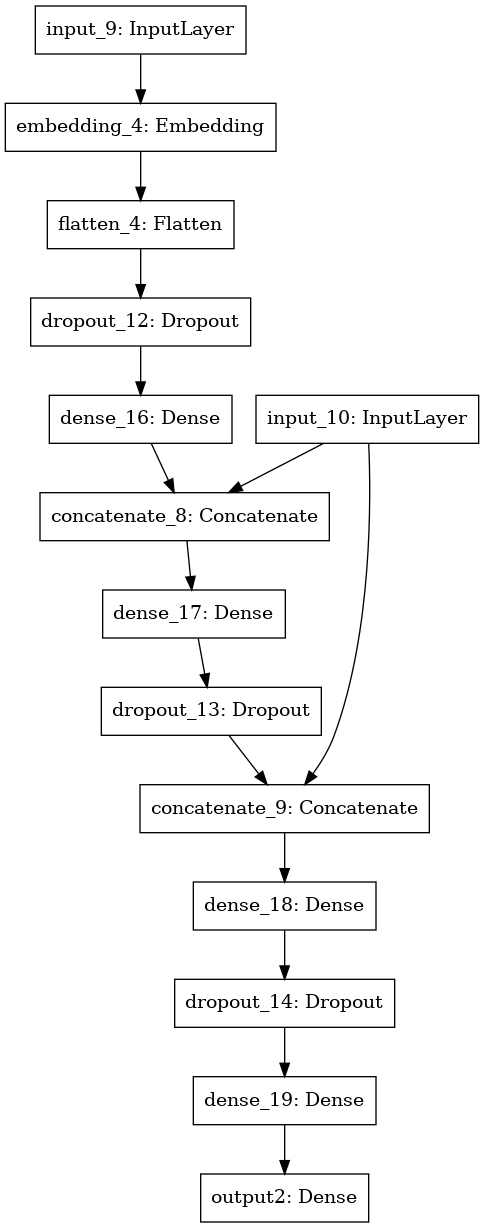

<h1> 2 inputs : Numerical within bins and Catergorical (Onehot)

In [ ]:
import numpy as np 
import pandas as pd 
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation,  BatchNormalization, Dropout, Concatenate, Embedding,  Flatten, Conv1D
from tensorflow.keras.models import Model
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras

from sklearn.metrics import roc_auc_score
import gc

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-oct-2021/train.csv')
test =  pd.read_csv('../input/tabular-playground-series-oct-2021/test.csv')

In [ ]:
y = train['target']
train.drop(['target','id'], axis = 1, inplace = True)
test.drop('id', axis = 1, inplace = True)

In [ ]:
cat_col = [col for col in train.columns if train[col].nunique() < 5]
num_col = [col for col in train.columns if col not in cat_col]
train_num = train[num_col]
train_cat = train[cat_col]
test_num = test[num_col]
test_cat = test[cat_col]

In [ ]:
del train, test
gc.collect()

In [ ]:
bin_cat = KBinsDiscretizer(n_bins=300, encode='ordinal',strategy='uniform')
train_num = pd.DataFrame(bin_cat.fit_transform(train_num))
test_num = pd.DataFrame(bin_cat.transform(test_num))
gc.collect()

In [ ]:
N_round = 1
N_split = 5
BATCH_SIZE=1024
EPOCH = 100

train_final = np.zeros((y.shape[0],1))
pred_final = np.zeros((test_num.shape[0],1))

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

with tpu_strategy.scope():
    
    for i in range (0,N_round):

        train_round = np.zeros((y.shape[0],1))

        skf = StratifiedKFold(n_splits = N_split, random_state = 2021, shuffle = True)

        for fold, (train_idx, val_idx) in enumerate(skf.split(train_num, y)):

            xtrain_num = train_num.iloc[train_idx,:]
            xtrain_cat = train_cat.iloc[train_idx,:]
            ytrain = y[train_idx]

            xval_num = train_num.iloc[val_idx,:]
            xval_cat = train_cat.iloc[val_idx,:]
            yval = y[val_idx]

            print('\n>>>>>> TRAINING STARTING FOR FOLD = ',fold+1)

            # NN model :
            input_num = Input(shape = (train_num.shape[1]))
            
            X = Embedding (input_dim=301, output_dim=8)(input_num)

            X = Flatten()(X)
            X = Dropout(0.3)(X)
            
            input_cat = Input(shape = (train_cat.shape[1]))
            
            X = Dense(64, 
                    kernel_initializer=tf.keras.initializers.GlorotNormal(), 
                    activation='swish')(X)
            
            W = Concatenate()([X,input_cat])
            W = Dense(64, 
                    kernel_initializer=tf.keras.initializers.GlorotNormal(), 
                    activation='swish')(W)
            W = Dropout(0.3)(W)
            W = Concatenate()([W,input_cat])
            W = Dense(64, 
                    kernel_initializer=tf.keras.initializers.GlorotNormal(), 
                    activation='swish')(W)
            
            W = Dropout(0.2)(W)
            W= Dense(16, 
                    kernel_initializer=tf.keras.initializers.GlorotNormal(), 
                    activation='swish')(W)
            
            output1 = Dense(1, 
                    kernel_initializer=tf.keras.initializers.GlorotNormal(),
                    activation='sigmoid', name='output2')(W)

            model = Model(inputs = [input_num,input_cat],
                   outputs = output1,
                   name='model')

            # Training control :
            es = tf.keras.callbacks.EarlyStopping(
            monitor='val_aucroc', min_delta=1e-06, patience=7, verbose=0,
            mode='max', baseline=None, restore_best_weights=True)
            plateau = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_aucroc', factor=0.5, patience=4, verbose=0,
            mode='max')

            # Fit :
            METRICS=[tf.keras.metrics.AUC(name='aucroc')]
            OPTIMIZER = keras.optimizers.Adam(learning_rate=0.001)
            model.compile(loss='binary_crossentropy', optimizer = OPTIMIZER, metrics=METRICS) 
            model.fit(
                    [xtrain_num,xtrain_cat],ytrain,
                    epochs = EPOCH,
                    batch_size = BATCH_SIZE,
                    validation_data = ([xval_num,xval_cat],yval),
                    verbose = 0,
                    callbacks=[es,plateau]
                    )

            # NN prediction
            pred = model.predict([xval_num,xval_cat])
            train_round[val_idx] = pred
            pred_final += model.predict([test_num,test_cat])/(N_split * N_round)
            print('\nFOLD = ',fold+1,"SCORE NN =",roc_auc_score(yval, pred))

        train_final += train_round/N_round
        print('\nROUND =',i+1,"SCORE NN =",roc_auc_score(y, train_round)) 


In [ ]:
sub = pd.read_csv('../input/tabular-playground-series-oct-2021/sample_submission.csv')
sub['target']=pred_final
sub.to_csv('pred_nn.csv',index=False)